In [1]:
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
from pathlib import Path

base_path = Path('datasets/flowers_split')
train_path = base_path / 'train'
val_path = base_path / 'validation'
test_path = base_path / 'test'

classes = ('daisy', 'dandelion', 'rose', 'sunflower', 'tulip')

In [3]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(7, 4))
# plt.plot([i+1 for i in range(epochs)], history.history['acc'], '-o', c='k', lw=2, markersize=9)
# plt.grid(True)
# plt.title("Training accuracy with epochs\n", fontsize=18)
# plt.xlabel("Training epochs", fontsize=15)
# plt.ylabel("Training accuracy", fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# display(plt)

def plot_training_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

# Building a Simple Convolutional Neural Network
* Create a simple convolutional network and train a model with the train set. You can start from the architecture proposed by Chollet, Listing 5.5 (in Chollet's notebook 5.2), and a small number of epochs. Use the ImageDataGenerator class to scale your images as in the book:

        train_datagen = ImageDataGenerator(rescale=1. / 255)
        val_datagen = ImageDataGenerator(rescale=1. / 255)
        test_datagen = ImageDataGenerator(rescale=1. / 255)
                    

* You will need to modify some parameters so that your network handles multiple classes.
* You will also adjust the number of steps so that your generator in the fitting procedure sees all the samples.
* You will report the training and validation losses and accuracies and comment on the possible overfit.
* Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.
* Try to improve your model by modifying some parameters and evaluate your network again.


In [4]:
import keras
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator

def build_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))

    print(model.summary())

    model.compile(optimizer=keras.optimizers.RMSprop(),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=[keras.metrics.categorical_accuracy])
    
    return model
    

def train(img_dim, batch_size, epochs, classes, augmentation):
    model = build_model(input_shape=img_dim)

    val_datagen = ImageDataGenerator(rescale=1. / 255)
    train_datagen = val_datagen if not augmentation else ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    generator_args = {
        'target_size': img_dim[:2],
        'batch_size': batch_size,
        'classes': classes,
        'class_mode': 'categorical'
    }

    train_generator = train_datagen.flow_from_directory(
            str(train_path),
            **generator_args)

    validation_generator = val_datagen.flow_from_directory(
            str(val_path),
            **generator_args)

    # ------------------------------------------------------------------------------------------------

    history = model.fit_generator(
            train_generator,
            steps_per_epoch=np.ceil(train_generator.samples / batch_size),
            validation_data=validation_generator,
            validation_steps=np.ceil(validation_generator.samples / batch_size),
            epochs=epochs,
            verbose=1)
    
    plot_training_history(history)

    # ------------------------------------------------------------------------------------------------

    return model

Using TensorFlow backend.


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

def test_simple_model(img_dim, batch_size, classes, epochs, model):
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    test_generator = test_datagen.flow_from_directory(str(test_path),
                                                      target_size=img_dim[:2],
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      shuffle=False)

    y_proba = model.predict_generator(test_generator, np.ceil(test_generator.samples / batch_size))
    y_pred = np.argmax(y_proba, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(test_generator.classes, y_pred))
    print('Classification Report')
    print(classification_report(test_generator.classes, y_pred, target_names=classes))

## Simple model no augmentation results

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

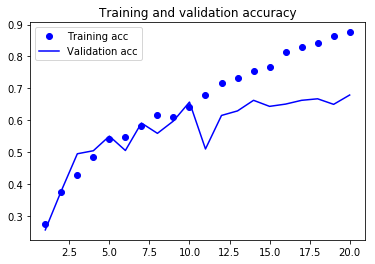

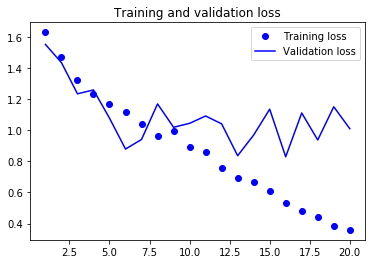

Found 865 images belonging to 5 classes.
Confusion Matrix
[[103  16  25  11  20]
 [ 29 102  39  22  23]
 [ 12   6  82   3  45]
 [  9  10   4 104  13]
 [ 15   3  38  18 113]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.61      0.59      0.60       175
   dandelion       0.74      0.47      0.58       215
        rose       0.44      0.55      0.49       148
   sunflower       0.66      0.74      0.70       140
       tulip       0.53      0.60      0.56       187

    accuracy                           0.58       865
   macro avg       0.60      0.59      0.59       865
weighted avg       0.60      0.58      0.58       865



In [17]:
train_args = {
    'img_dim': (64,64,3),
    'batch_size': 128,
    'epochs':20,
    'classes':classes
}

model = train(**train_args, augmentation=False)
test_simple_model(**train_args, model=model)

# Using Image Augmentation
* The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides a built-in class for this: ImageDataGenerator. You will reuse it and apply it to the flower data set.

* Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 5.11 (in notebook 5.2 also).
* Report the training and validation losses and accuracies and comment on the possible overfit.
* Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

## Simple model augmentation results

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

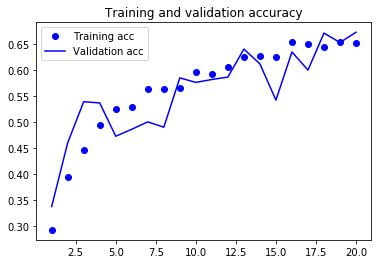

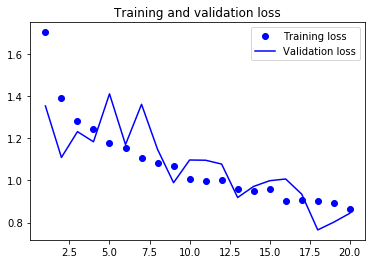

Found 865 images belonging to 5 classes.
Confusion Matrix
[[107  19  15  12  22]
 [  6 159   9  20  21]
 [  4   8  85   2  49]
 [  4   7   1 123   5]
 [  5  11  20  19 132]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.85      0.61      0.71       175
   dandelion       0.78      0.74      0.76       215
        rose       0.65      0.57      0.61       148
   sunflower       0.70      0.88      0.78       140
       tulip       0.58      0.71      0.63       187

    accuracy                           0.70       865
   macro avg       0.71      0.70      0.70       865
weighted avg       0.72      0.70      0.70       865



In [20]:
model = train(**train_args, augmentation=True)

test_simple_model(**train_args, model=model)

# Using a Pretrained Convolutional Base
*Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments (http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.*


## Feature extraction without data augmentation

* *Build a network that consists of the Inception V3 convolutional base and two dense layers. As in Chollet, Listing 5.17 (in Chollet's notebook 5.3), you will program an extract_features() function.*
* *Train your network and report the training and validation losses and accuracies.*
* *Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.*

In [37]:
epochs=20
batch_size = 128
img_dim = (150, 150, 3)

In [38]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=img_dim)

conv_output_shape = conv_base.layers[-1].output_shape[1:]
print(conv_output_shape)

(3, 3, 2048)


In [39]:
from keras.preprocessing.image import ImageDataGenerator

def count_files(path, extension):
    return len(list(path.glob('**/*.{extension}'.format(extension=extension))))

def extract_features(path):
    sample_count = count_files(path, 'jpg')
    
    features = np.zeros(shape=(sample_count, *conv_output_shape))
    labels = np.zeros(shape=(sample_count, len(classes)))
    
    datagen = ImageDataGenerator(rescale=1 / 255)
    generator = datagen.flow_from_directory(
        str(path),
        classes=classes,
        target_size=img_dim[:2],
        batch_size=batch_size,
        class_mode='categorical',
    )

    for i, (inputs_batch, labels_batch) in enumerate(generator):
        if i * batch_size >= sample_count: break
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        
    return features.reshape(-1, np.prod(conv_output_shape)), labels

In [40]:
x_train, y_train = extract_features(train_path)
x_val, y_val = extract_features(val_path)
x_test, y_test = extract_features(test_path)

Found 2594 images belonging to 5 classes.
Found 1265 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [41]:
np.save('x_train', x_train)
np.save('x_val', x_val)
np.save('x_test', x_test)

np.save('y_train', y_train)
np.save('y_val', y_val)
np.save('y_test', y_test)

In [42]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

In [43]:
model = Sequential([
    Dense(256, activation='relu', input_dim=np.prod(conv_output_shape)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.RMSprop(lr=2e-5),
    loss=keras.losses.categorical_crossentropy,
    metrics=[keras.metrics.categorical_accuracy]
)

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
    )

model.save('feature-extraction-1.h5')

Train on 2594 samples, validate on 1265 samples
Epoch 1/20
2594/2594 [==============================] - 1s 538us/step - loss: 1.7086 - categorical_accuracy: 0.4437 - val_loss: 0.9319 - val_categorical_accuracy: 0.6237
Epoch 2/20
2594/2594 [==============================] - 0s 169us/step - loss: 0.9879 - categorical_accuracy: 0.6184 - val_loss: 0.8036 - val_categorical_accuracy: 0.6885
Epoch 3/20
2594/2594 [==============================] - 0s 172us/step - loss: 0.8129 - categorical_accuracy: 0.6823 - val_loss: 0.6961 - val_categorical_accuracy: 0.7423
Epoch 4/20
2594/2594 [==============================] - 0s 168us/step - loss: 0.6998 - categorical_accuracy: 0.7375 - val_loss: 0.7036 - val_categorical_accuracy: 0.7439
Epoch 5/20
2594/2594 [==============================] - 0s 168us/step - loss: 0.6125 - categorical_accuracy: 0.7637 - val_loss: 0.6366 - val_categorical_accuracy: 0.7771
Epoch 6/20
2594/2594 [==============================] - 0s 166us/step - loss: 0.5324 - categorical_acc

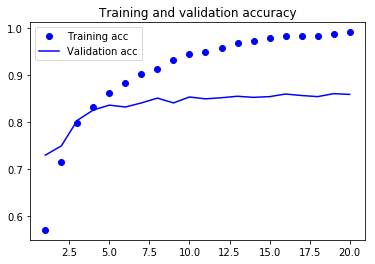

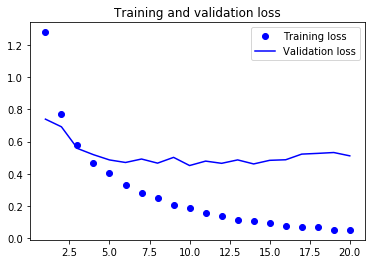

In [34]:
plot_training_history(history)

In [ ]:
# from keras.models import load_model
# model = load_model('feature-extraction-1.h5')plot_training_history

In [44]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
y_pred = model.predict_classes(x_test)

865/865 [==============================] - 0s 133us/step


In [45]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=classes))

[[150   3   8   5   9]
 [  9 183   6  13   4]
 [  5   2 107   8  26]
 [  6   7   4 114   9]
 [  5   3  22   4 153]]
              precision    recall  f1-score   support

       daisy       0.86      0.86      0.86       175
   dandelion       0.92      0.85      0.89       215
        rose       0.73      0.72      0.73       148
   sunflower       0.79      0.81      0.80       140
       tulip       0.76      0.82      0.79       187

    accuracy                           0.82       865
   macro avg       0.81      0.81      0.81       865
weighted avg       0.82      0.82      0.82       865



## Feature extraction with data augmentation
* *Modify your program to include an image transformer. Train a new model.*
* *Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.*

In [53]:
img_dim = (150, 150, 3)
epochs = 20
batch_size = 128

In [54]:
conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=img_dim)

model2 = Sequential([
    conv_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])
print('trainable before freeze: ', len(model2.trainable_weights))

conv_base.trainable = False

print('trainable: ', len(model2.trainable_weights))

model2.summary()

trainable before freeze:  192
trainable:  4
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 1285      
Total params: 26,522,917
Trainable params: 4,720,133
Non-trainable params: 21,802,784
_________________________________________________________________


In [55]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        str(train_path),
        target_size=img_dim[:2],
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        str(val_path),
        target_size=img_dim[:2],
        batch_size=batch_size,
        class_mode='categorical')

model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=[keras.metrics.categorical_accuracy])

history2 = model2.fit_generator(
      train_generator,
      steps_per_epoch=np.ceil(train_generator.samples / batch_size),
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=np.ceil(validation_generator.samples / batch_size))

model2.save('feature-extraction-2.h5')

Found 2594 images belonging to 5 classes.
Found 1265 images belonging to 5 classes.
Epoch 1/20
21/21 [==============================] - 19s 883ms/step - loss: 12.1984 - categorical_accuracy: 0.3273 - val_loss: 4.3998 - val_categorical_accuracy: 0.4269
Epoch 2/20
21/21 [==============================] - 16s 748ms/step - loss: 1.6380 - categorical_accuracy: 0.4830 - val_loss: 2.7321 - val_categorical_accuracy: 0.4498
Epoch 3/20
21/21 [==============================] - 19s 882ms/step - loss: 1.6023 - categorical_accuracy: 0.5439 - val_loss: 2.2197 - val_categorical_accuracy: 0.4775
Epoch 4/20
21/21 [==============================] - 19s 885ms/step - loss: 1.2369 - categorical_accuracy: 0.5894 - val_loss: 3.7623 - val_categorical_accuracy: 0.4711
Epoch 5/20
21/21 [==============================] - 19s 881ms/step - loss: 1.0613 - categorical_accuracy: 0.6361 - val_loss: 3.7097 - val_categorical_accuracy: 0.5209
Epoch 6/20
21/21 [==============================] - 19s 882ms/step - loss: 1.117

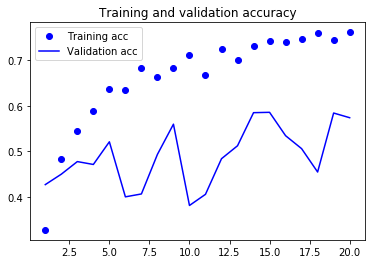

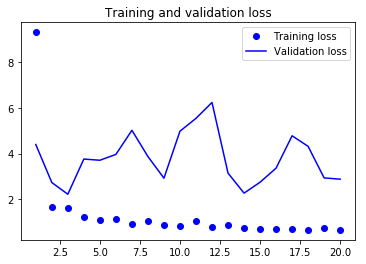

In [56]:
plot_training_history(history2)

In [57]:
test_generator = test_datagen.flow_from_directory(
        str(test_path),
        target_size=img_dim[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
)

test_loss, test_accuracy = model2.evaluate_generator(
    test_generator,
    steps=np.ceil(test_generator.samples / batch_size)
)

y_proba = model2.predict_generator(
    test_generator,
    steps=np.ceil(test_generator.samples / batch_size)
)
y_pred = np.argmax(y_proba, axis=1)

print(confusion_matrix(test_generator.classes, y_pred))
print(classification_report(test_generator.classes, y_pred))

Found 865 images belonging to 5 classes.
[[161   2   1   6   5]
 [ 63  64   3  79   6]
 [ 23   1  60  45  19]
 [ 47   4   2  82   5]
 [ 20   4   8  31 124]]
              precision    recall  f1-score   support

           0       0.51      0.92      0.66       175
           1       0.85      0.30      0.44       215
           2       0.81      0.41      0.54       148
           3       0.34      0.59      0.43       140
           4       0.78      0.66      0.72       187

    accuracy                           0.57       865
   macro avg       0.66      0.57      0.56       865
weighted avg       0.68      0.57      0.56       865

